In [1]:
import genome
from genome import Genom, Node, crossover, distance
import numpy as np
import operator
import copy
from time import sleep
import gymnasium as gym
import torch
from operator import itemgetter
import random

In [2]:
env = gym.make("CartPole-v1")

## Erstellung eines Genoms mit einem input und zwei output Knoten

In [3]:
genom = Genom(2,1)

## Printen der Knoten und Connections

In [4]:
genom.p_nodes()
genom.p_connections()

===== Input Nodes =====
Key: -2 Type: input Bias: -1.2349444033405335
Key: -1 Type: input Bias: -0.016875951341966993
===== Hidden Nodes =====
===== Output Nodes =====
Key: 0 Type: output Bias: 0.2682983574799707

===== Connections =====
-2 --> 0 Weight: -1.2041513376631214 is active : True
-1 --> 0 Weight: 0.763955859002727 is active : True



## Visualisierung

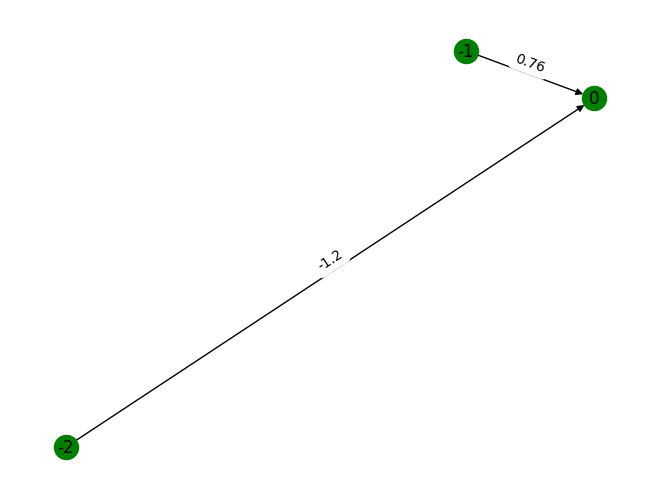

In [5]:
genom.visualize(color="green")

## Forwardpass

In [6]:
genom.forward([1,1])

[(0, -0.20097240868277977)]

## Mutation

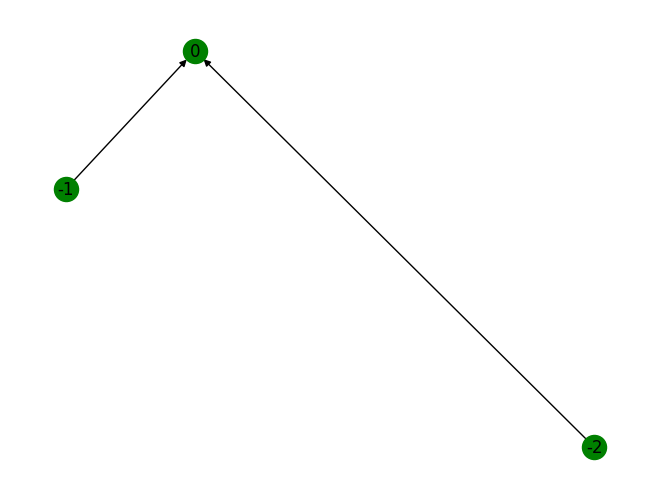

In [7]:
for _ in range(10):
    genom.mutate()
genom.visualize(labels=False, color="green")

In [8]:
genom.p_nodes()
genom.p_connections()

===== Input Nodes =====
Key: -2 Type: input Bias: -1.2920641359703593
Key: -1 Type: input Bias: 0.33800667186130434
===== Hidden Nodes =====
===== Output Nodes =====
Key: 0 Type: output Bias: 0.7170378749048185

===== Connections =====
-2 --> 0 Weight: -1.1823868332000276 is active : True
-1 --> 0 Weight: 0.30146231070898716 is active : True



In [9]:
genom.forward([1,1])

[(0, -0.5433727641057136)]

## Erstellung von zwei neuen Genomen

In [10]:
genom1 = Genom(2,1)
genom2 = Genom(2,1)

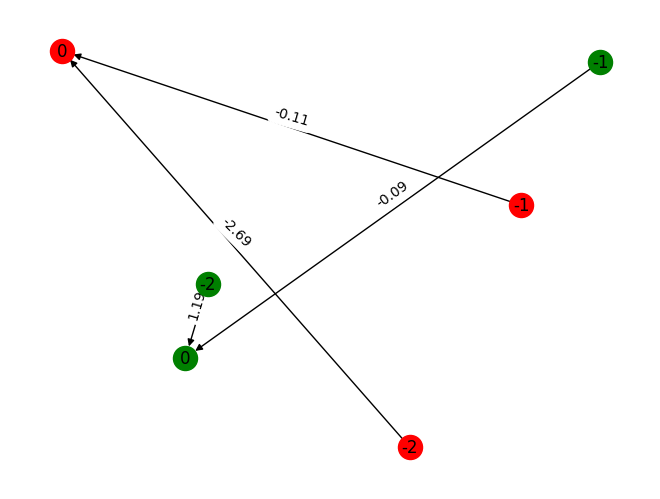

In [11]:
genom1.visualize(color="red")
genom2.visualize(color="green")

## Crossover

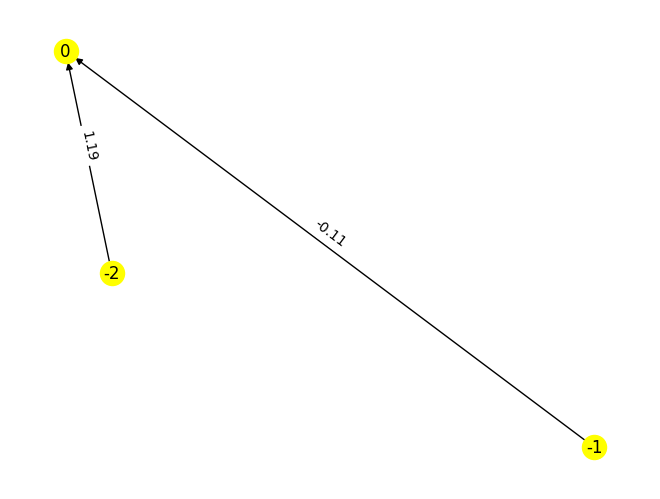

In [12]:
cros_genom = crossover(genom1,genom2)
cros_genom.visualize(color="yellow")

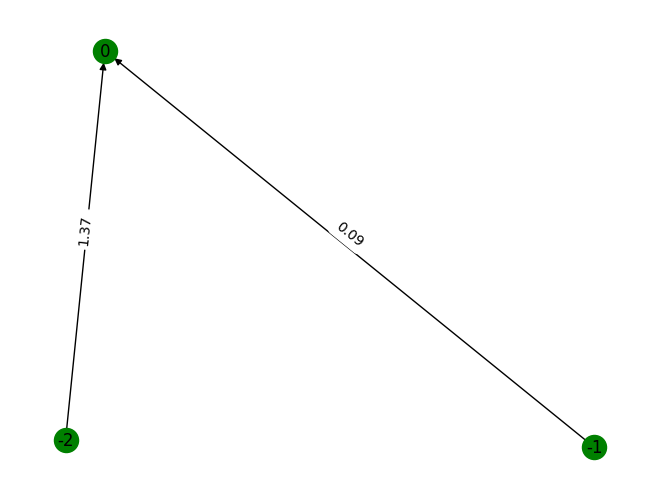

In [13]:
for _ in range(5):
    genom2.mutate()

genom2.visualize(color="green")

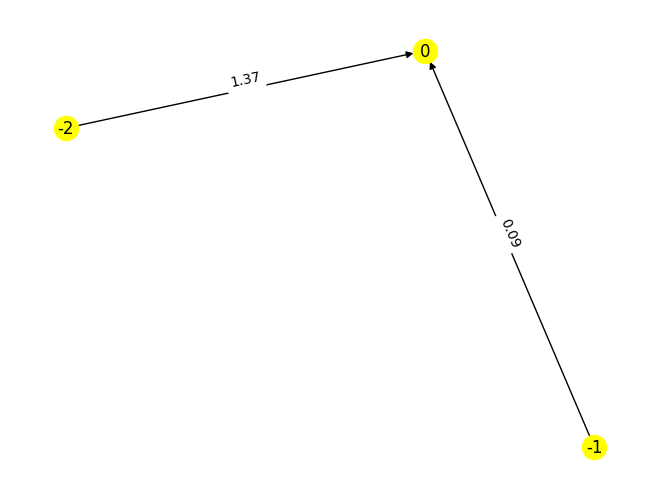

In [14]:
cros_genom = crossover(genom1,genom2)
cros_genom.visualize(color="yellow")

In [15]:
cros_genom.p_nodes()
cros_genom.p_connections()

===== Input Nodes =====
Key: -2 Type: input Bias: -0.6570994661180058
Key: -1 Type: input Bias: 0.2801122947985741
===== Hidden Nodes =====
===== Output Nodes =====
Key: 0 Type: output Bias: -0.01721383241677136

===== Connections =====
-2 --> 0 Weight: 1.3658921226417673 is active : True
-1 --> 0 Weight: 0.08799564698402099 is active : True



In [16]:
cros_genom.forward([1,1])

[(0, -0.07609001844593322)]

## Distance

In [17]:
distance(genom1,genom2)

-0.13444131798783873

In [18]:
class Agent():
    
    def __init__(self, obs_dim = env.observation_space.shape, n_actions = env.action_space.n, 
                 eps = 0.05, eps_dec = 1e-5, eps_min = 0.05, popSize=20):
        
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.action_space = [i for i in range(n_actions)]
        self.eps = eps
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.popSize = popSize
        self.population = [(Genom(4,2),0) for _ in range(self.popSize)]


    #Choose the next action, based on the current state
    def pick_action(self, state, nn):
        if np.random.random() > self.eps:
            actions = [nn.forward(state)]
            action = max(actions, key=itemgetter(1))[0][0]
        else:
            action = np.random.choice(self.action_space)
        self.eps -= self.eps_dec if self.eps > self.eps_min else 0
        return action
    
    def train(self, epochs = 100):
        self.population = self.fitness(3, self.population)
        for i in range(epochs):
            
            #print frequenz
            if i % 25 == 0:
                print("Epoch: " + str(i), end=" ")
                print("Score: " +str(self.population[0][1]))

            #early break up
            if(self.population[0][1] >= 450):
               return self.population[0][0]
            
            #crossover
            random.shuffle(self.population)
            child_pop = []
            for i in range(0, len(self.population), 2):
                child_pop.append((crossover(self.population[i][0], self.population[i+1][0],
                                           self.population[i][1], self.population[i+1][1]), 0))
                
            #mutation
            self.mutation(child_pop)

            #calc fitness
            self.population += self.fitness(3, child_pop)

            #selection
            self.selection()

        return self.population[0][0]
            

    #Calculates the fitness of a population. The fitness is the average score after "reps" games 
    def fitness(self, reps, pop):
        new_pop = []
        for p in pop:
            sum = 0
            for _ in range(reps):
                sum += self.play(p[0])
            new_pop.append((p[0],sum/reps))
        return new_pop
    

    def selection(self):
        """Elitist Selection"""
        sortedPop = sorted(self.population, key=operator.itemgetter(1), reverse=True)
        self.population = sortedPop[:self.popSize]
            
    #mutates the childrens
    def mutation(self, children):
        for c in children:
            c[0].mutate()

    #play the game once and return the score
    def play(self, nn: Genom):
        obs, _ = env.reset()
        obs = torch.tensor(obs, dtype=torch.float)
        score = 0
        terminated = False
        truncated = False
        while not terminated and not truncated:
            action = self.pick_action(obs, nn)
            obs_, reward, terminated, truncated, _ = env.step(action)
            obs = torch.tensor(obs_, dtype=torch.float)
            score += 1
        return score
            

In [21]:
agent = Agent(popSize=20, eps=0.6)

Epoch: 0 Score: 12.333333333333334
Epoch: 25 Score: 27.666666666666668
Epoch: 50 Score: 27.666666666666668
Epoch: 75 Score: 27.666666666666668
Epoch: 100 Score: 27.666666666666668
Epoch: 125 Score: 27.666666666666668
Epoch: 150 Score: 27.666666666666668
Epoch: 175 Score: 27.666666666666668
Epoch: 200 Score: 27.666666666666668
Epoch: 225 Score: 27.666666666666668
Epoch: 250 Score: 27.666666666666668
Epoch: 275 Score: 27.666666666666668
===== Connections =====
-4 --> 0 Weight: 1.3512889622603528 is active : False
-4 --> 1 Weight: 0.2874377509168238 is active : False
-3 --> 0 Weight: -3.9056771989478034 is active : False
-3 --> 1 Weight: -2.6796592801782646 is active : False
-2 --> 0 Weight: -1.730916033179146 is active : False
-2 --> 1 Weight: 0.8117248964284067 is active : False
-1 --> 0 Weight: 0.5273984977242439 is active : False
-1 --> 1 Weight: 1.2986964177205926 is active : False
-3 --> 2 Weight: -1.718022543920307 is active : False
2 --> 1 Weight: -3.9938812658431515 is active : F

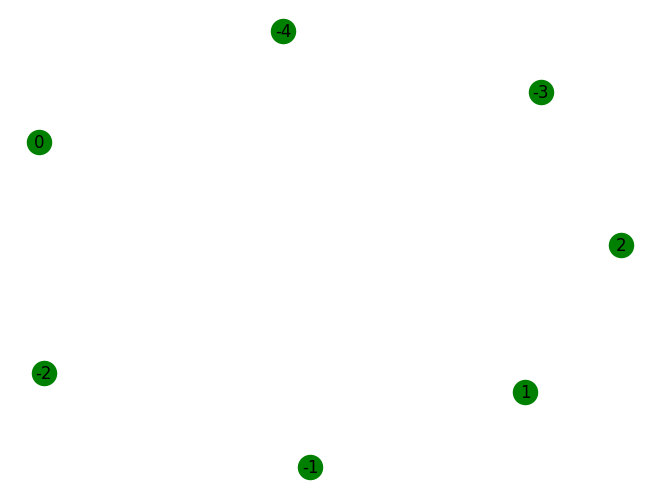

In [22]:
best = agent.train(epochs=300)
best.p_connections()
best.p_nodes()
best.visualize()

In [23]:
class NN():

    def __init__(self, popSize = 2, n_In = 2, n_Out = 1) -> None:
        self.population = [(Genom(n_In,n_Out),0) for _ in range(popSize)] 
        self.popSize = popSize

    def forwardpass(self, index,x):
        return self.population[index][0].forward(x)

    def mutate(self,pop):
        for p in pop:
            p[0].mutate()

     #Calculates the fitness of a population. The fitness is the average score after "reps" games 
    def fitness(self, reps, pop):
        new_pop = []
        for p in pop:
            sum = 0
            for _ in range(reps):
                sum += self.play(p[0])
            new_pop.append((p[0],sum/reps))
        return new_pop
    

    def selection(self):
        """Elitist Selection"""
        sortedPop = sorted(self.population, key=operator.itemgetter(1), reverse=True)
        self.population = sortedPop[:self.popSize]

    def fitness(sel, pop):
        new_pop = []
        for p in pop:
            tmp = 0

            if np.round(p[0].forward([0,0])[0][1]) == 0:
                tmp += 0.25
            if np.round(p[0].forward([0,1])[0][1]) == 1:
                tmp += 0.25
            if np.round(p[0].forward([1,0])[0][1]) == 1:
                tmp += 0.25
            if np.round(p[0].forward([1,1])[0][1]) == 0:
                tmp += 0.25
            #print(genom.forward([0,0]))

            new_pop.append((p[0],tmp))

        return new_pop

            
    
    def train(self, epochs = 100):
        for i in range(epochs):
            
            print("Epoch: " + str(i), end=" ")
            print("Acc: " +str(self.population[0][1]))

            if(self.population[0][1] == 1):
               return self.population[0][0]
            '''for p in self.population:
                p[0].p_nodes()
                p[0].p_connections()'''

            #crossover
            random.shuffle(self.population)
            child_pop = []
            for i in range(0, len(self.population), 2):
                child_pop.append((crossover(self.population[i][0], self.population[i+1][0],
                                           self.population[i][1], self.population[i+1][1]), 0))
                
            self.mutate(child_pop)
            
            self.population += self.fitness(child_pop)

            self.selection()

        return self.population[0][0]
            
            

Epoch: 0 Acc: 0
Epoch: 1 Acc: 0.75
Epoch: 2 Acc: 0.75
Epoch: 3 Acc: 0.75
Epoch: 4 Acc: 0.75
Epoch: 5 Acc: 0.75
Epoch: 6 Acc: 0.75
Epoch: 7 Acc: 0.75
Epoch: 8 Acc: 0.75
Epoch: 9 Acc: 0.75
Epoch: 10 Acc: 0.75
Epoch: 11 Acc: 0.75
Epoch: 12 Acc: 0.75
Epoch: 13 Acc: 0.75
Epoch: 14 Acc: 0.75
Epoch: 15 Acc: 0.75
Epoch: 16 Acc: 0.75
Epoch: 17 Acc: 0.75
Epoch: 18 Acc: 0.75
Epoch: 19 Acc: 0.75
Epoch: 20 Acc: 0.75
Epoch: 21 Acc: 0.75
Epoch: 22 Acc: 0.75
Epoch: 23 Acc: 0.75
Epoch: 24 Acc: 0.75
Epoch: 25 Acc: 0.75
Epoch: 26 Acc: 0.75
Epoch: 27 Acc: 0.75
Epoch: 28 Acc: 0.75
Epoch: 29 Acc: 0.75
Epoch: 30 Acc: 0.75
Epoch: 31 Acc: 0.75
Epoch: 32 Acc: 0.75
Epoch: 33 Acc: 0.75
Epoch: 34 Acc: 0.75
Epoch: 35 Acc: 0.75
Epoch: 36 Acc: 0.75
Epoch: 37 Acc: 0.75
Epoch: 38 Acc: 0.75
Epoch: 39 Acc: 0.75
Epoch: 40 Acc: 0.75
Epoch: 41 Acc: 0.75
Epoch: 42 Acc: 0.75
Epoch: 43 Acc: 0.75
Epoch: 44 Acc: 0.75
Epoch: 45 Acc: 0.75
Epoch: 46 Acc: 0.75
Epoch: 47 Acc: 0.75
Epoch: 48 Acc: 0.75
Epoch: 49 Acc: 0.75
Epoch: 50 Acc

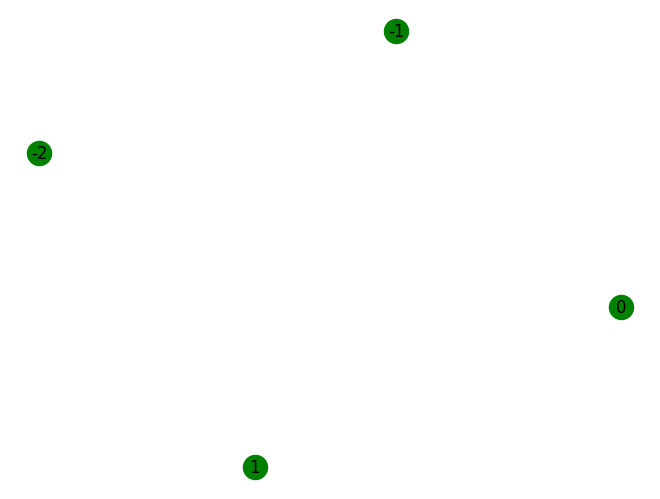

In [24]:
nn = NN(popSize=100)
best = nn.train()
best.visualize()
